# Welcome to the Prognostics Model Package Tutorial

The goal of this notebook is to instruct users on how to use and extend the NASA PCoE Python Prognostics Model Package (prog_models). 

First some background. The Prognostics Model Package is a python package for the modeling and simulation of the evolution of state for components, systems, and systems of systems, with a focus on simulating specific events. When used for prognostics, these events are typically system failures, such as a winding failure on a motor or full discharge of a battery. 

A few definitions:
* __Event__: Something that can be predicted (e.g., system failure, warning threshold). An event has either occurred or not. 
* __Event State__: Progress towards event occurring. Defined as a number where an event state of 0 indicates the event has occurred and 1 indicates no progress towards the event (i.e., fully healthy operation for a failure event). For gradually occurring events (e.g., discharge) the number will progress from 1 to 0 as the event nears. In prognostics, event state is frequently called "State of Health" or "SOH"
* __Inputs__: Control applied to the system being modeled (e.g., current drawn from a battery)
* __Outputs__: Measured sensor values from a system (e.g., voltage and temperature of a battery), outputs can be estimated from system state
* __States__: Internal parameters (typically hidden states) used to represent the state of the system- can be the same as inputs/outputs but do not have to be.

The `prog_models` package has the following structure
* `prog_models.data_models` - package containing algorithms for data-driven models, and parent class `prog_models.data_models.DataModel`
* `prog_models.datasets` - package containing tools for downloading a few relevant datasets
* `prog_models.loading` - package containing tools for representing different loading profiles
* `prog_models.models.*` - implemented models (e.g., pump, valve, battery)
* `prog_models.utils.*` - various utility functions and classes
* `prog_models.CompositeModel` - model of a system-of-systems, combining multiple interrelated models into a single model
* `prog_model.EnsembleModel` - model combining multiple models of the same system into a single model
* `prog_models.LinearModel` - parent class for simple linear models
* `prog_models.PrognosticsModel` - parent class for all prognostics models - defines interfaces that a model must implement, and tools for simulating said model 

In addition to the `prog_models` package, the GitHub repository includes many examples illustrating how to use the package (see `examples/`), a template for implementing a new model (`prog_model_template`), and this tutorial (`tutorial.ipynb`). Documentation  for prog_models and the full ProgPy can be found at <https://nasa.github.io/progpy>,

Before you start, make sure to install prog_models using the following command:

    pip install prog_models

Now let's get started with some examples

## Using the included models

This first example is for using the included prognostics models. 

The `prog_models.models` package includes implemented models, including ones for pumps, valves, and batteries. See <https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html> for a full description of the included models.

First thing to do is to import the model you would like to use:

In [4]:
from prog_models.models import BatteryCircuit

This imports the BatteryCircuit model distributed with the `prog_models` package. See <https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html> for details on this model.

Next, let's create a new battery using the default settings:

In [5]:
batt = BatteryCircuit()

This creates a battery circuit model. You can also pass configuration parameters into the constructor as keyword arguments to configure the system, for example
### <center>`BatteryCircuit(qMax = 7856)`</center>
Alternatively, you can set the configuration of the system afterwards, like so:

In [6]:
batt.parameters['qMax'] = 7856 
batt.parameters['process_noise'] = 0  # Note: by default there is some process noise- this turns it off. Noise will be explained later in the tutorial

These parameters describe the specific system (in this case battery) the model is simulating. See <https://nasa.github.io/progpy/api_ref/prog_models/IncludedModels.html> for a full list of configurable model parameters. Let's use the model properties to check out some details of this model, first the model configuration:

In [7]:
from pprint import pprint
print('Model configuration:')
pprint(batt.parameters)

Model configuration:
{'CMax': 7777,
 'Cb0': 1878.155726,
 'Cbp0': -230,
 'Cbp1': 1.2,
 'Cbp2': 2079.9,
 'Cbp3': 27.055726,
 'Ccp': 14.8223,
 'Cs': 234.387,
 'Jt': 800,
 'Rcp0': 0.0697776,
 'Rcp1': 1.50528e-17,
 'Rcp2': 37.223,
 'Rp': 10000.0,
 'Rs': 0.0538926,
 'Ta': 292.1,
 'V0': 4.183,
 'VDropoff': 0.1,
 'VEOD': 3.0,
 'ha': 0.5,
 'hcp': 19,
 'hcs': 1,
 'measurement_noise': {'t': 0.0, 'v': 0.0},
 'process_noise': {'tb': 0.0, 'qb': 0.0, 'qcp': 0.0, 'qcs': 0.0},
 'qMax': 7856,
 'x0': {'qb': 7856.3254, 'qcp': 0, 'qcs': 0, 'tb': 292.1}}


You can save or load your model configuration using pickle

In [8]:
import pickle
pickle.dump(batt.parameters, open('battery123.cfg', 'wb'))

Then you can set your model configuration like below. This is useful for recording and restoring model configurations. Some users store model configuration as picked files to be restored from later.

In [9]:
batt.parameters = pickle.load(open('battery123.cfg', 'rb'))

Information is passed to and from the model using containers that function like dictionaries. The keys of the containers are specific to the model.

Let's look at the inputs (loading) and outputs (measurements) for a BatteryCircuit model. These are the keys expected for inputs and outputs, respectively.

In [10]:
print('inputs: ', batt.inputs)
print('outputs: ', batt.outputs)

inputs:  ['i']
outputs:  ['t', 'v']


Now let's look at what events we're predicting. This model only predicts one event, called EOD (End of Discharge), but that's not true for every model. See <https://nasa.github.io/prog_models/models.html>

In [11]:
print('event(s): ', batt.events)

event(s):  ['EOD']


Finally, let's take a look at the internal states that the model uses to represent the system:

In [12]:
print('states: ', batt.states)

states:  ['tb', 'qb', 'qcp', 'qcs']


## Simulating to a specific time

Now let's simulate. The following section uses the model created in the "using the included models" section

First, we define future loading. This is a function that describes how the system will be loaded as a function of time. Here we're defining a basic piecewise function.

In [16]:
from prog_models.loading import Piecewise
# Variable (piece-wise) future loading scheme 
future_loading = Piecewise(batt.InputContainer, [600, 900, 1800, 3000, float('inf')], {'i': [2, 1, 4, 2, 3]})

Note that future loading can be modeled using various classes in prog_models.loading or as any function f(t: float, x: StateContainer) -> InputContainer.

At last it's time to simulate. First we're going to simulate forward 200 seconds. To do this we use the function simulate_to() to simulate to the specified time and print the results.

In [19]:
time_to_simulate_to = 200
sim_config = {
    'save_freq': 20, 
    'print': True  # Print states - Note: is much faster without
}
(times, inputs, states, outputs, event_states) = batt.simulate_to(time_to_simulate_to, future_loading, **sim_config)

Time: 0.0
	Input: {'i': 2.0}
	State: {'tb': 292.1, 'qb': 7856.3254, 'qcp': 0.0, 'qcs': 0.0}
	Output: {'t': 292.1, 'v': 4.1828702595530105}
	Event State: {'EOD': 1.0000418413269898}

Time: 20.0
	Input: {'i': 2.0}
	State: {'tb': 292.22644204150873, 'qb': 7816.317409660615, 'qcp': 2.0689378843844732, 'qcs': 20.41326287692566}
	Output: {'t': 292.22644204150873, 'v': 3.950865081712307}
	Event State: {'EOD': 0.9948974424148921}

Time: 40.0
	Input: {'i': 2.0}
	State: {'tb': 292.3610888245951, 'qb': 7776.309533253024, 'qcp': 2.0689354519476315, 'qcs': 24.33552608303554}
	Output: {'t': 292.3610888245951, 'v': 3.9288409870976757}
	Event State: {'EOD': 0.9897530581526326}

Time: 60.0
	Input: {'i': 2.0}
	State: {'tb': 292.49484966409074, 'qb': 7736.301684463998, 'qcp': 2.068934546518363, 'qcs': 25.089157295472866}
	Output: {'t': 292.49484966409074, 'v': 3.9203754582002106}
	Event State: {'EOD': 0.9846086774416868}

Time: 80.0
	Input: {'i': 2.0}
	State: {'tb': 292.6271089174722, 'qb': 7696.29384941

We can also plot the results. Here we see the temperature of the battery increase and the voltage decrease with use. This is expected. Voltage will decrease as the state of charge decreases, and temperature increases as current is drawn through the battery, until it reaches some equilibrium. Everything is very linear because the load is kept constant within the simulation window. 

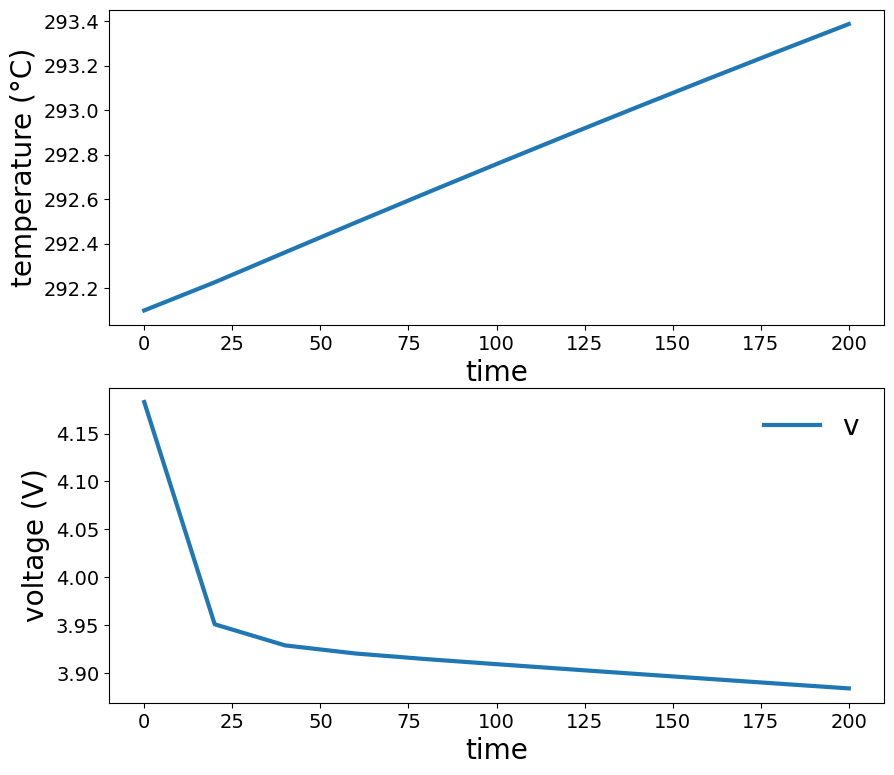

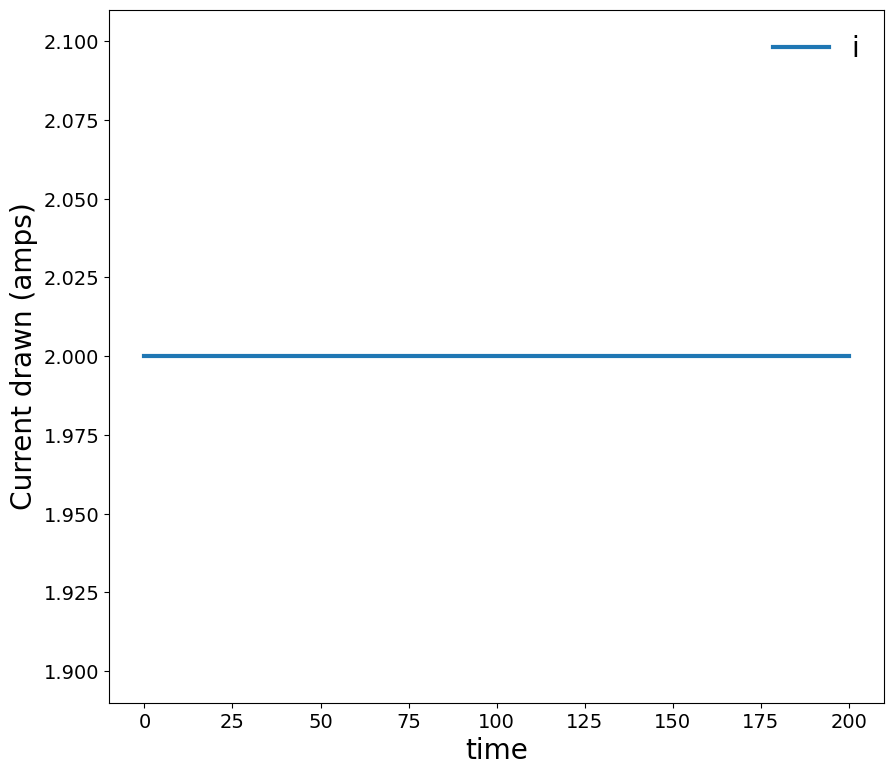

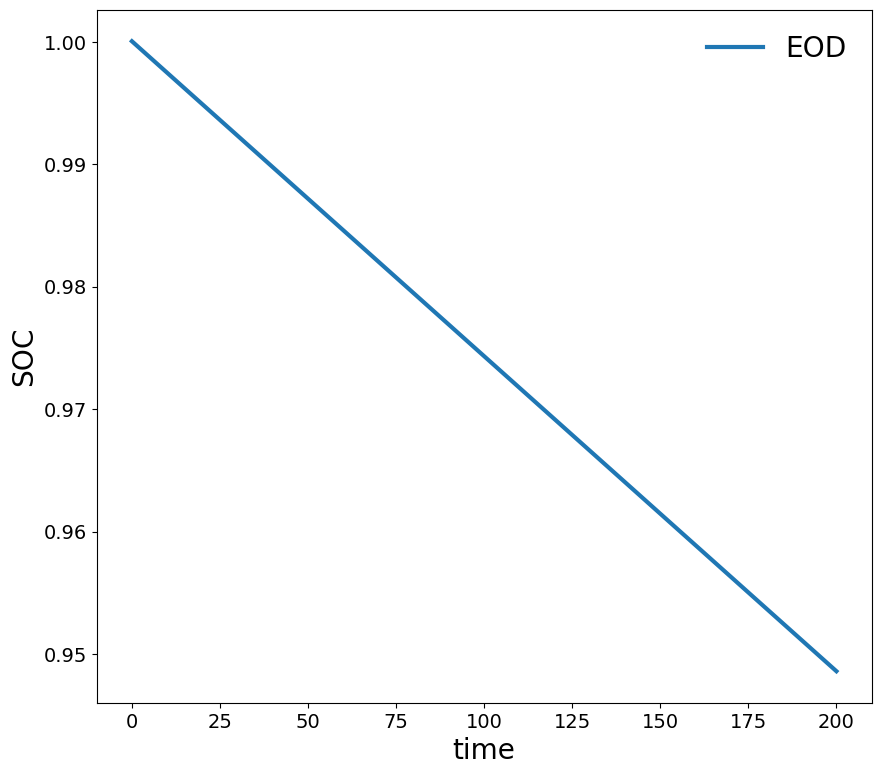

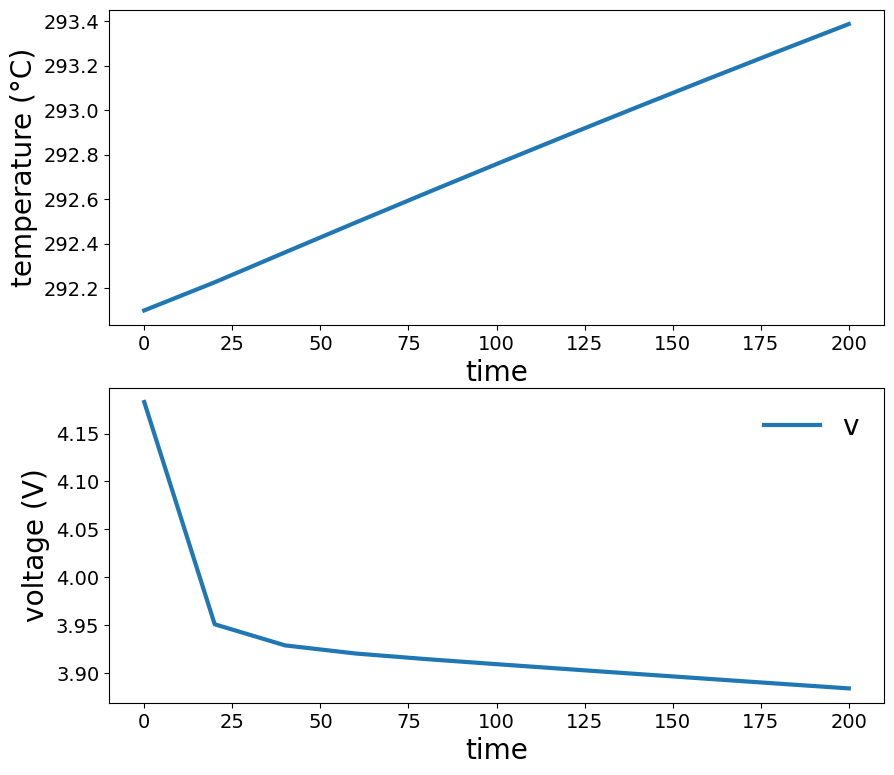

In [18]:
inputs.plot(ylabel='Current drawn (amps)')
event_states.plot(ylabel= 'SOC')
outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)

Also, note the the lack of smoothness in the voltage curve. This is limited by the save_freq from sim_cfg. There is a point on the graph every 20 seconds, because that is the frequency at which we save the results. Decreasing the save frequency will result in a cleaner curve.

The results can be further analyzed with available metrics. For example, monotonicity can be calculated for simulate_to()'s returned objects. The End of Discharge (EOD) event state (i.e., State of Charge) should be monotonic (i.e., decreasing monotonicly). Note: the EOD event is specific to the battery model. Each model will simulate different events.

The monotonicity metric indicates the degree of monoticity where 1 is completely monotonic and 0 is perfecly non-monotonic (decreasing as much as increasing)

In [20]:
print('monotonicity: ', event_states.monotonicity())

monotonicity:  {'EOD': 1.0}


Lastly, results can be stored in a container variable and be individually accessed via namedtuple syntax.

In [21]:
batt_simulation = batt.simulate_to(time_to_simulate_to, future_loading, save_freq = 20)
print('times: ', batt_simulation.times) 
print('\ninputs: ', batt_simulation.inputs)
print('\nstates: ', batt_simulation.states)
print('\noutputs: ', batt_simulation.outputs) 
print('\nevent states: ', batt_simulation.event_states)

times:  [0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0]

inputs:  [{'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}, {'i': 2.0}]

states:  [{'tb': 292.1, 'qb': 7856.3254, 'qcp': 0.0, 'qcs': 0.0}, {'tb': 292.22644204150873, 'qb': 7816.317409660615, 'qcp': 2.0689378843844732, 'qcs': 20.41326287692566}, {'tb': 292.3610888245951, 'qb': 7776.309533253024, 'qcp': 2.0689354519476315, 'qcs': 24.33552608303554}, {'tb': 292.49484966409074, 'qb': 7736.301684463998, 'qcp': 2.068934546518363, 'qcs': 25.089157295472866}, {'tb': 292.6271089174722, 'qb': 7696.293849418812, 'qcp': 2.0689339377980582, 'qcs': 25.233957148618543}, {'tb': 292.7577558424454, 'qb': 7656.286025387842, 'qcp': 2.068933389371525, 'qcs': 25.261774177023153}, {'tb': 292.8867852787106, 'qb': 7616.2782117833385, 'qcp': 2.0689328557918225, 'qcs': 25.267113779720262}, {'tb': 293.0142124723636, 'qb': 7576.270408429509, 'qcp': 2.068932328305495

## Simulating to threshold

Instead of specifying a specific amount of time, we can also simulate until a threshold has been met using the simulate_to_threshold() method. Results can be similarly plotted and accessed via namedtuple syntax.

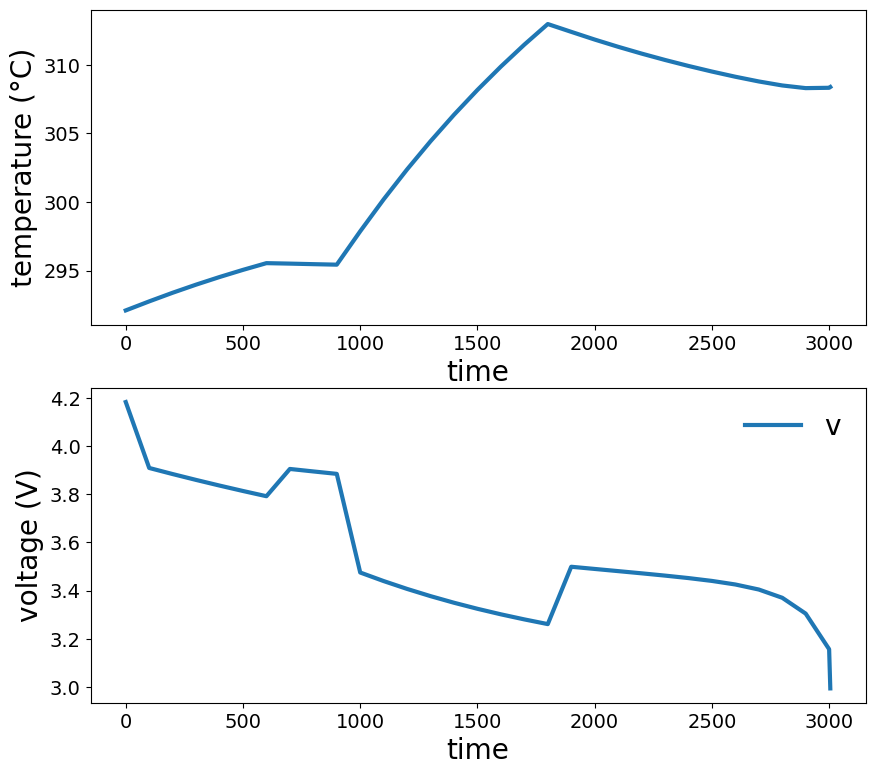

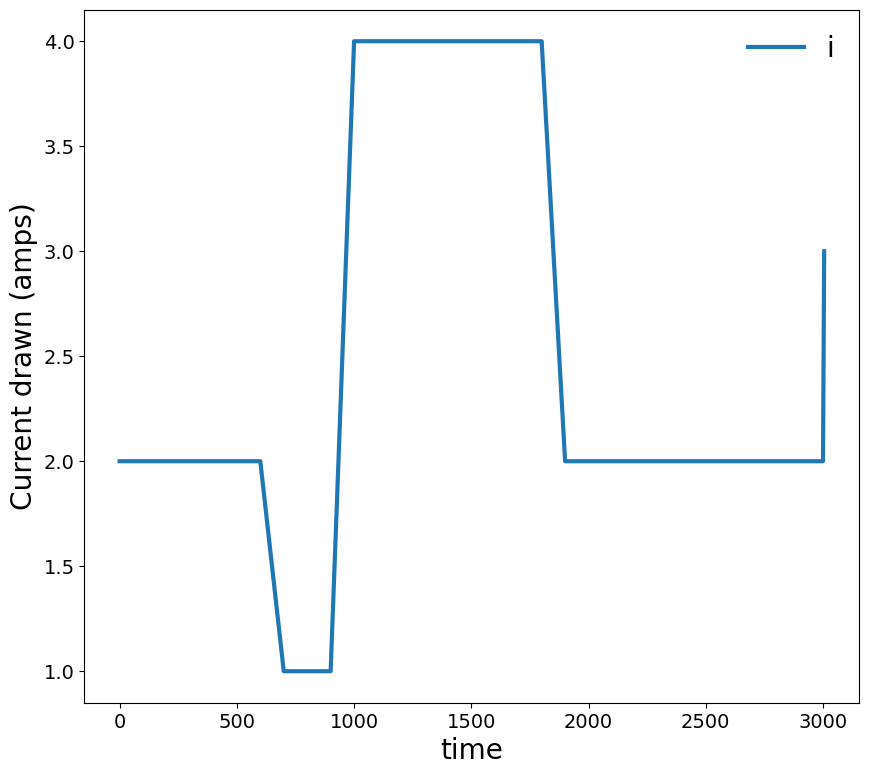

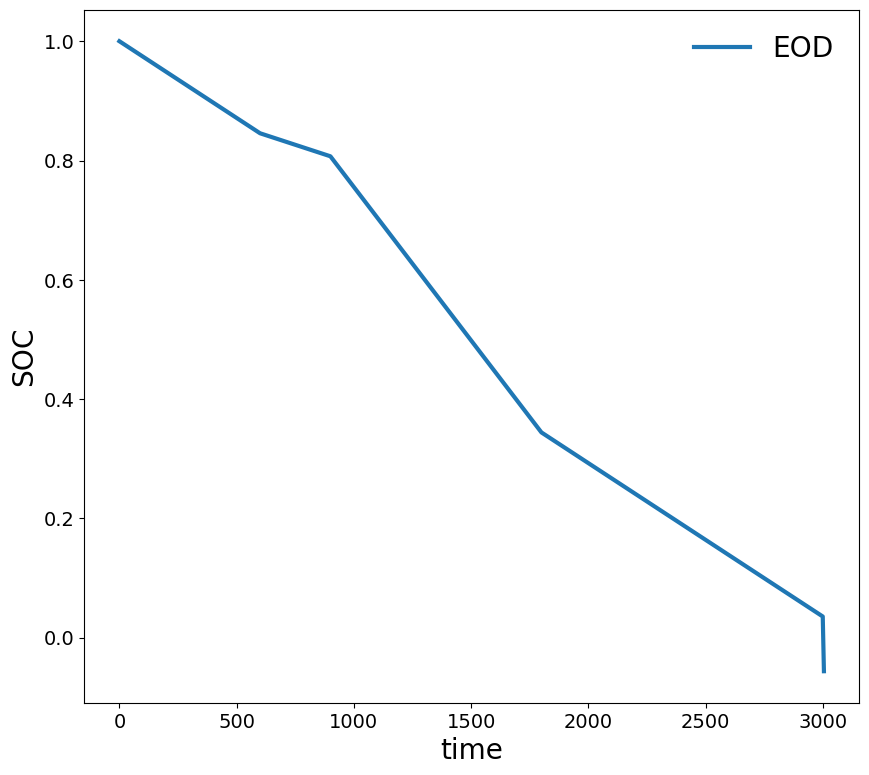

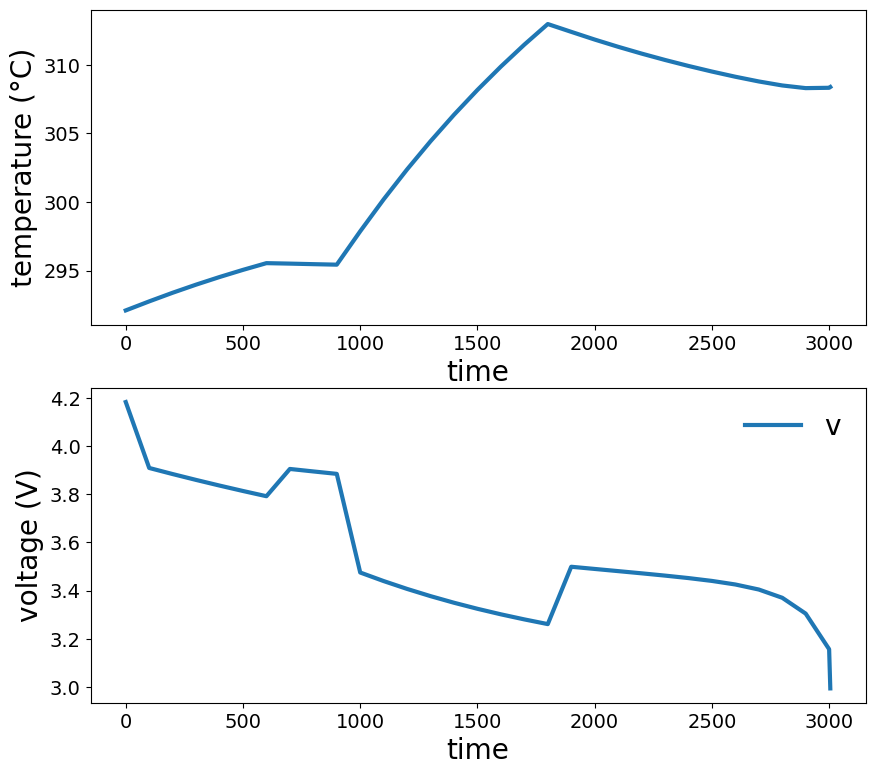

In [22]:
options = { #configuration for this sim
    'save_freq': 100,  # Frequency at which results are saved (s)
    'horizon': 5000  # Maximum time to simulate (s) - This is a cutoff. The simulation will end at this time, or when a threshold has been met, whichever is first
    }
(times, inputs, states, outputs, event_states) = batt.simulate_to_threshold(future_loading, **options)
inputs.plot(ylabel='Current drawn (amps)')
event_states.plot(ylabel='SOC')
outputs.plot(ylabel= {'v': "voltage (V)", 't': 'temperature (°C)'}, compact= False)

One thing to note here is that unlike the earlier plots, these plots are not smooth curves, this is because the load is piecewise, not constant. You see jumps in the plots at the times when the load changes. Also, the simulation is long enough for the temperature to reach an equilibrium. 

Default is to simulate until any threshold is met, but we can also specify which event we are simulating to (any key from model.events) for multiple event models. See `examples.sim_battery_eol` for an example of this.

## Noise

There are three types of noise that can be added to a model in simulation, described below:
* __Process Noise__: Noise representing uncertainty in the model transition; e.g., model or model configuration uncertainty, uncertainty from simplifying assumptions. Applied during state transition
* __Measurement Noise__: Noise representing uncertainty in the measurement process; e.g., sensor sensitivity, sensor misalignments, environmental effects. Applied during estimation of outputs from states.
* __Future Loading Noise__: Noise representing uncertainty in the future loading estimates; e.g., uncertainty from incomplete knowledge of future loading. Responsibility of user to apply in supplied future loading method

The amount of process or measurement noise is considered a property of the model and can be set using the m.parameters['process_noise'] and m.parameters['measurement_noise'], respectively.

In this example we will use the ThrownObject model and turn off process noise. ThrownObject is a simple model of an object thrown directly into the air in a vacuum. Thrown object simulates two events: 'falling' (when the object starts falling) and 'impact' (when the object hits the ground). More details can be found later in the tutorial.

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	0.50s: {'x': 20.35092591060207, 'v': 34.07855124289541}
	1.00s: {'x': 36.12822744263126, 'v': 28.393737692901528}
	1.50s: {'x': 48.9812214219364, 'v': 22.99846684410669}
	2.00s: {'x': 59.18332628263409, 'v': 17.784029484245163}
	2.50s: {'x': 66.81357749367159, 'v': 12.705288070826589}
	3.00s: {'x': 71.92955924357045, 'v': 7.721366562656726}
	3.50s: {'x': 74.56918342157253, 'v': 2.794268972436784}
	4.00s: {'x': 74.75187498447991, 'v': -2.1113986020335997}
	4.50s: {'x': 72.51970359869338, 'v': -6.951038077083324}
	5.00s: {'x': 67.84376796132159, 'v': -11.78994457815374}
	5.50s: {'x': 60.767651534582804, 'v': -16.545494944171786}
	6.00s: {'x': 51.34088892233225, 'v': -21.18640641142484}
	6.50s: {'x': 39.62791879000095, 'v': -25.684491985662305}
	7.00s: {'x': 25.706379318441126, 'v': -30.015262094408577}
	7.50s: {'x': 9.665150243939953, 'v': -34.158332454780265}
	7.78s: {'x': -0.02584293949765626, 'v': -36.35101411864478}

impact time: 7.78s


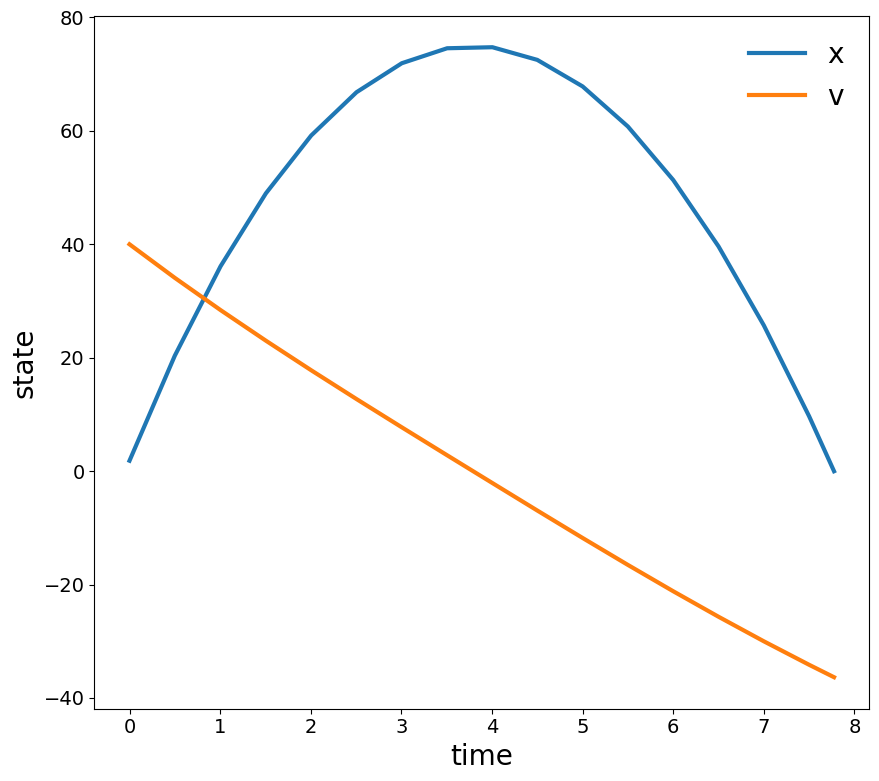

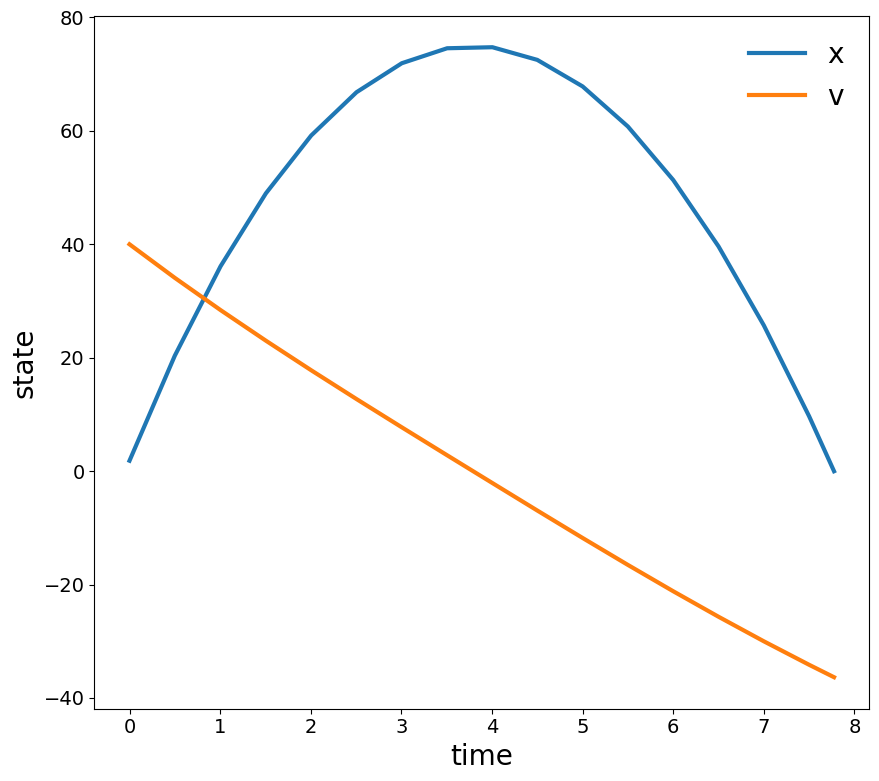

In [23]:
from prog_models.models import ThrownObject

# Create an instance of the thrown object model with no process noise
m = ThrownObject(process_noise=False)

# Define future loading
def future_load(t=None, x=None):  
    # The thrown object model has no inputs- you cannot load the system (i.e., effect it once it's in the air)
    # So we return an empty input container
    return m.InputContainer({})

# Define configuration for simulation
config = {
    'threshold_keys': 'impact', # Simulate until the thrown object has impacted the ground
    'dt': 0.005, # Time step (s)
    'save_freq': 0.5, # Frequency at which results are saved (s)
}

# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, **config)

# Print results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

print('\nimpact time: {:.2f}s'.format(times[-1]))
# The simulation stopped at impact, so the last element of times is the impact time

# Plot results
states.plot()

See above the velocity decreases linerally and the position follows a clean parabola, as we would expect.

Now with this second example we apply normal (i.e., gaussian) process noise with a standard deviation of 15 to every state. Compare the plots generated with those above- you should be able to see the effects of the noise

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	0.50s: {'x': 20.105685585457536, 'v': 33.607193153607504}
	1.00s: {'x': 34.68017023851567, 'v': 29.144242608268968}
	1.50s: {'x': 46.9165953408509, 'v': 22.616110352512003}
	2.00s: {'x': 57.49802958396498, 'v': 16.807523107974543}
	2.50s: {'x': 64.75053581298741, 'v': 11.25535720787832}
	3.00s: {'x': 68.77265568267538, 'v': 5.837432500055949}
	3.50s: {'x': 69.95946545850344, 'v': 1.7224144204111853}
	4.00s: {'x': 68.6560829411978, 'v': -2.1131349734008746}
	4.50s: {'x': 66.38790824791856, 'v': -8.42754932162857}
	5.00s: {'x': 61.228304104984076, 'v': -12.461808976842006}
	5.50s: {'x': 54.3223360092646, 'v': -17.611547697054007}
	6.00s: {'x': 45.6514297911771, 'v': -22.612516177395303}
	6.50s: {'x': 33.01571844907321, 'v': -28.03636174579685}
	7.00s: {'x': 18.26447813811736, 'v': -32.08203598027122}
	7.50s: {'x': 2.1388339361507125, 'v': -35.70090207826556}
	7.57s: {'x': -0.1493626143963386, 'v': -36.08616178902697}

impact time: 7.57s


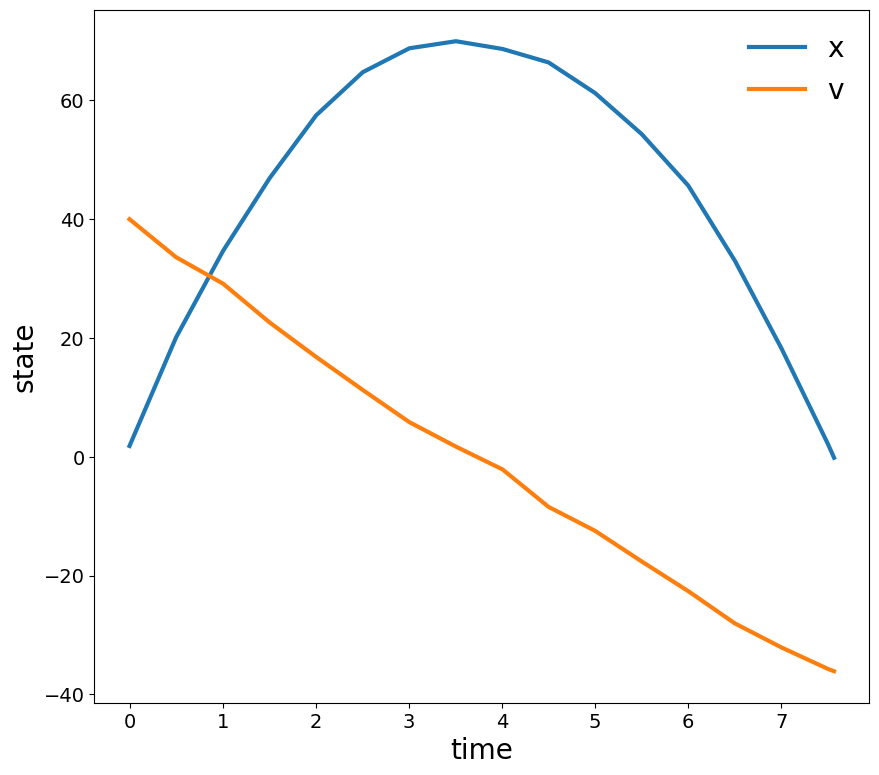

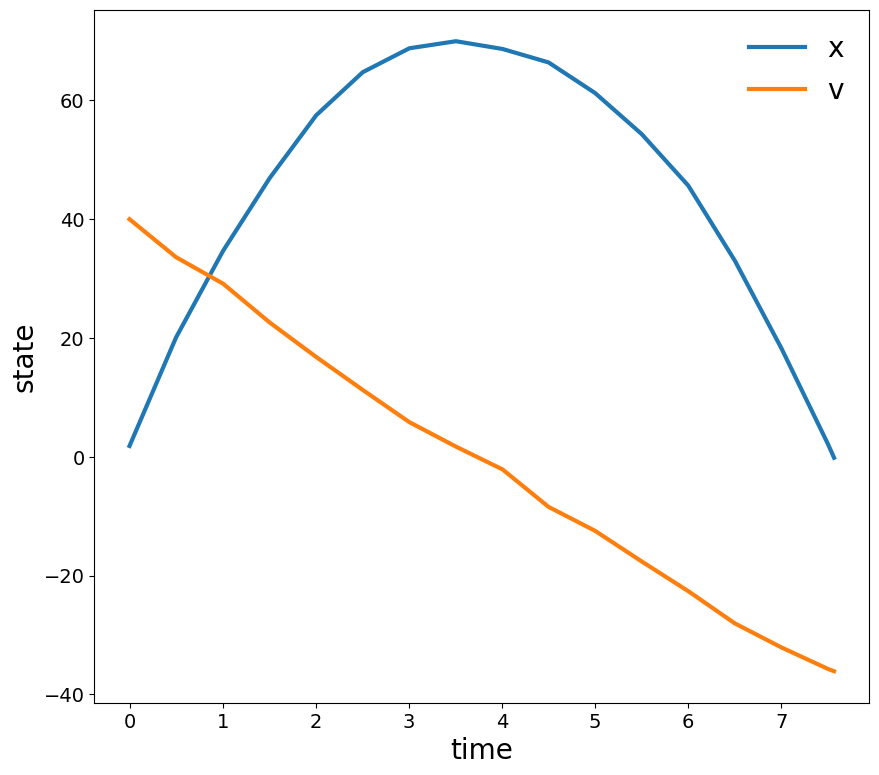

In [24]:
m = ThrownObject(process_noise = 15)

# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, **config)

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

print('\nimpact time: {:.2f}s'.format(times[-1]))

# Plot results
states.plot()

You can also specify different amounts of noise on different states, for example here we area applying no noise to velocity but a large amount of noise to the position. Compare the plot with that above. Here you should see a smooth curve for the velocity, but a noisy curve for position

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	0.50s: {'x': 21.371218393257365, 'v': 34.07855124289541}
	1.00s: {'x': 42.31037292666576, 'v': 28.393737692901528}
	1.50s: {'x': 50.98923951785948, 'v': 22.99846684410669}
	2.00s: {'x': 57.730253952154975, 'v': 17.784029484245163}
	2.50s: {'x': 66.06470939829725, 'v': 12.705288070826589}
	3.00s: {'x': 73.45084731351251, 'v': 7.721366562656726}
	3.50s: {'x': 75.13477770145498, 'v': 2.794268972436784}
	4.00s: {'x': 74.7919865212463, 'v': -2.1113986020335997}
	4.50s: {'x': 75.57584921204001, 'v': -6.951038077083324}
	5.00s: {'x': 68.76952123223434, 'v': -11.78994457815374}
	5.50s: {'x': 61.766744146088705, 'v': -16.545494944171786}
	6.00s: {'x': 53.50822396737091, 'v': -21.18640641142484}
	6.50s: {'x': 39.76695780334894, 'v': -25.684491985662305}
	7.00s: {'x': 27.516941155204524, 'v': -30.015262094408577}
	7.50s: {'x': 11.171955069629135, 'v': -34.158332454780265}
	7.87s: {'x': -0.11640686491670793, 'v': -37.05484770261243}

impact time: 7.87s


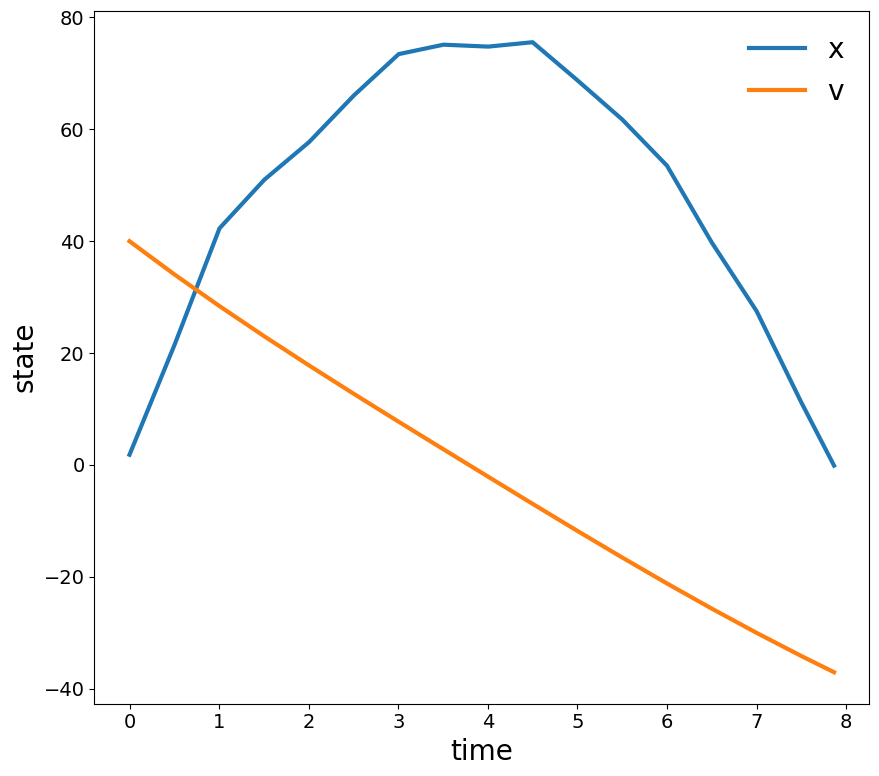

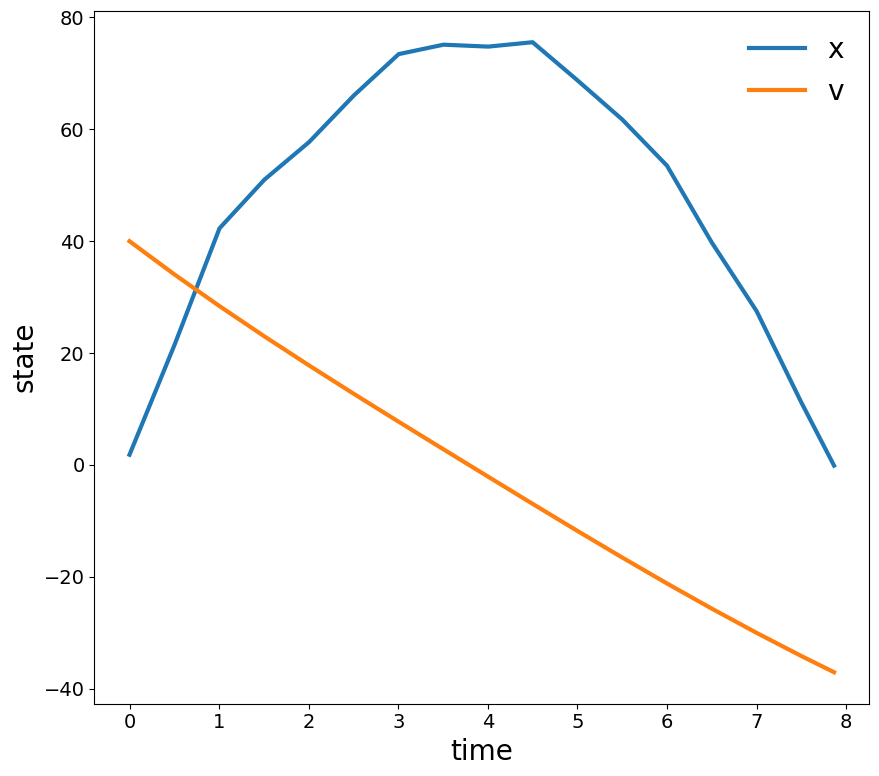

In [25]:
m = ThrownObject(process_noise = {'x': 50, 'v': 0})

# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, **config)

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

print('\nimpact time: {:.2f}s'.format(times[-1]))

# Plot results
states.plot()

You can also define the shape of the noise to be uniform or triangular instead of normal. Finally, you can define your own function to apply noise for anything more complex. 

For more information see `examples.noise`

## Simulating - advanced

There are a number of advanced features that can be used in simulation. A few of these will be described below. Detail can also be found in the documentation here: https://nasa.github.io/progpy/prog_models_guide.html#simulation

### Saving results at specific points

Earlier, we demonstrated how save_freq specifies the frequency at which the results are saved in simulation. There are occasionally circumstances when you need the results at a specific time (e.g., check points, waypoints, etc.). This is accomplished with the save_pts argument in simulation.

For example, in the following simple case, we're reusing the example from earlier, but we're saving the results at 1 second, 5 seconds, 6 seconds, and 7 seconds. 

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	1.00s: {'x': 36.12822744263126, 'v': 28.393737692901528}
	5.00s: {'x': 67.84376796132159, 'v': -11.78994457815374}
	6.00s: {'x': 51.34088892233225, 'v': -21.18640641142484}
	7.00s: {'x': 25.706379318441126, 'v': -30.015262094408577}
	7.78s: {'x': -0.02584293949765626, 'v': -36.35101411864478}


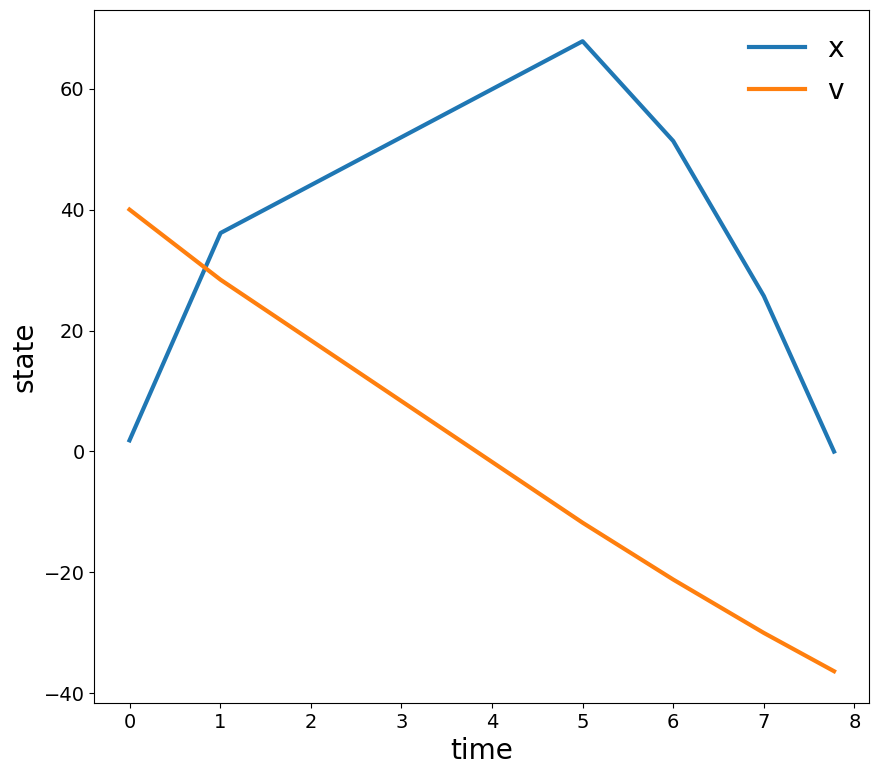

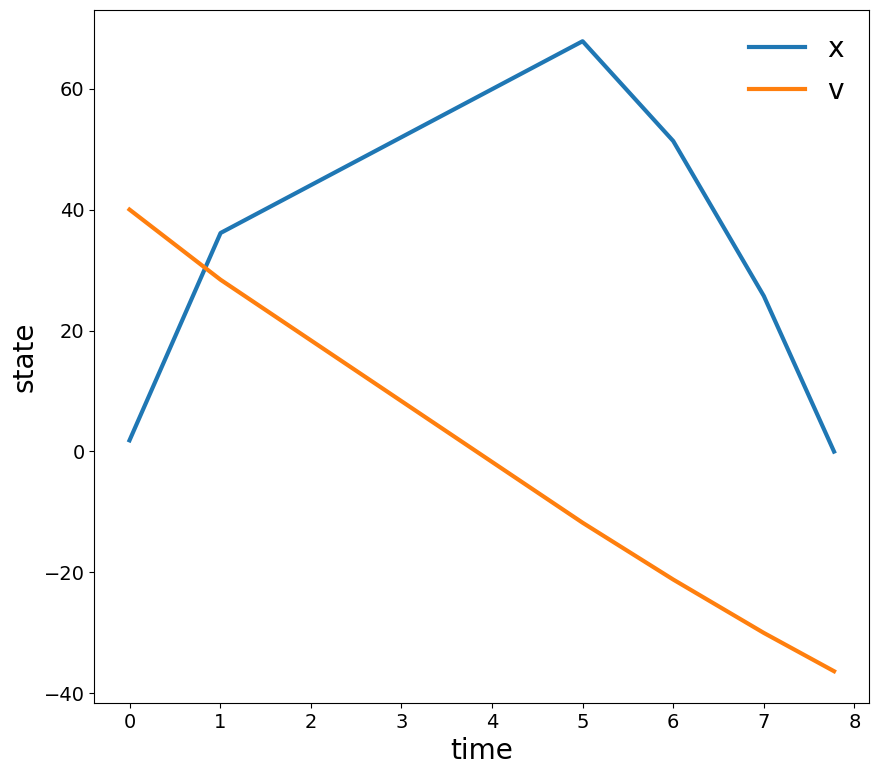

In [28]:
# Reset noise
m.parameters['process_noise'] = False
m.parameters['measurement_noise'] = False

# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, dt=config['dt'], threshold_keys='impact', save_pts=[1, 5, 6, 7])

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

# Plot results
states.plot()

Note that now we only have the data at the points specified (plus initial and final). As a result, the graph looks lopsided.

save_pts can also be used to adjust the save frequency as degradation progresses, for example by having more concentrated save pts around the end of degradation, like the example below.

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	1.00s: {'x': 36.12822744263126, 'v': 28.393737692901528}
	2.00s: {'x': 59.18332628263409, 'v': 17.784029484245163}
	3.00s: {'x': 71.92955924357045, 'v': 7.721366562656726}
	4.00s: {'x': 74.75187498447991, 'v': -2.1113986020335997}
	5.00s: {'x': 67.84376796132159, 'v': -11.78994457815374}
	5.50s: {'x': 60.767651534582804, 'v': -16.545494944171786}
	6.00s: {'x': 51.34088892233225, 'v': -21.18640641142484}
	6.25s: {'x': 45.7656148274979, 'v': -23.454925447265662}
	6.50s: {'x': 39.62791879000095, 'v': -25.684491985662305}
	6.75s: {'x': 32.937904466892306, 'v': -27.872165119525103}
	7.00s: {'x': 25.706379318441126, 'v': -30.015262094408577}
	7.10s: {'x': 22.664690143990576, 'v': -30.859469174430558}
	7.20s: {'x': 19.538943165967293, 'v': -31.696011824377155}
	7.30s: {'x': 16.329911325214695, 'v': -32.52475447115986}
	7.40s: {'x': 13.038380787599587, 'v': -33.34556853906928}
	7.50s: {'x': 9.665150243939953, 'v': -34.158332454780265}
	7.60s: {'x': 6.211

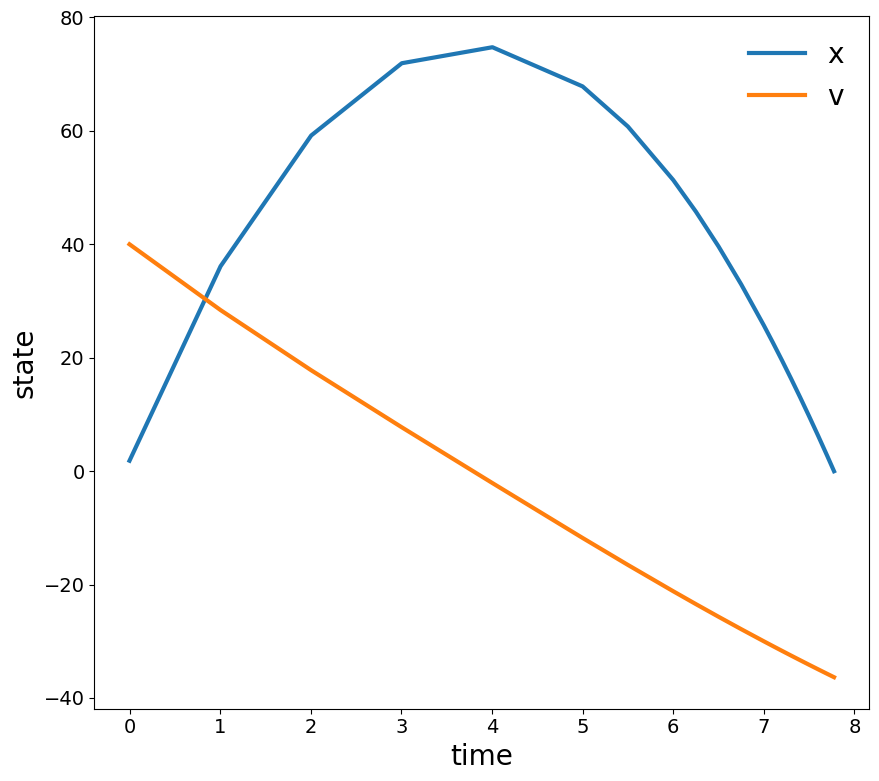

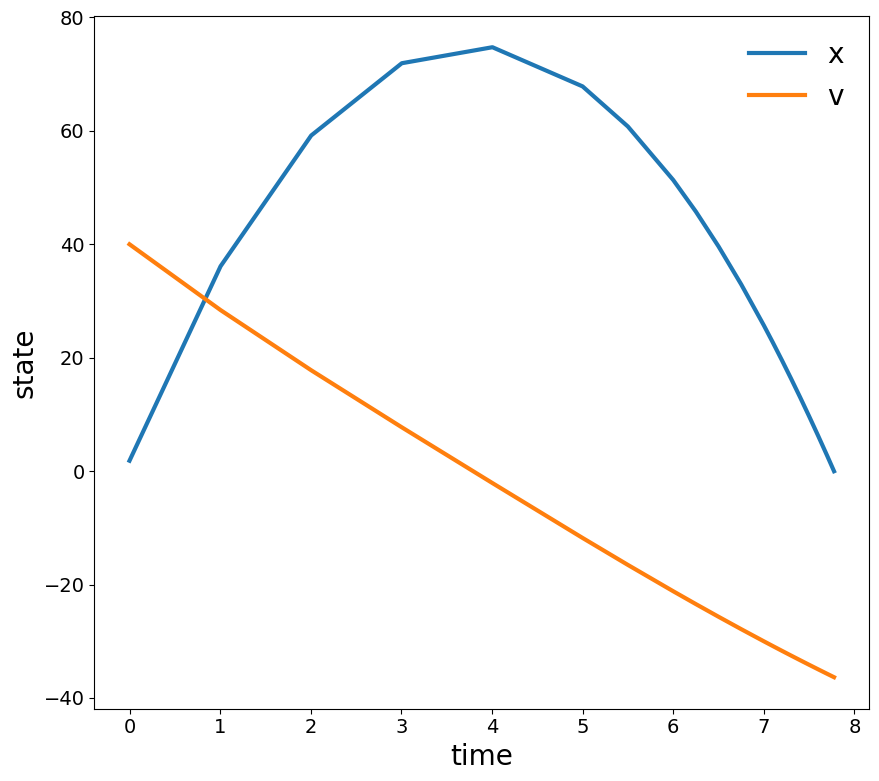

In [29]:
# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, dt=config['dt'], threshold_keys='impact', save_pts=[1, 2, 3, 4, 5, 5.5, 6, 6.25, 6.5, 6.75, 7, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8])

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

# Plot results
states.plot()

Now the curve is much better defined as the simulation progresses. This is frequently of interest since users are mostly interested in behavior close to the event occurance.

Keep in mind that using a fixed dt, like above, will only save the data at the closest dt increment at or after the save point. So if save_freq is less than dt, save points will be missed. or if save_pts are not a multiple of dt, the resulting point at which data is saved will not be exactly at the save point. Auto step sizes (see next section) can help with this.

### Step Sizes

At the end of the save_pts example above, we noted that save_pts are often not exactly met when they are not a multiple of dt. This can be seen in the example below.

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	1.20s: {'x': 42.73446807833005, 'v': 26.13844416533344}
	2.60s: {'x': 70.44222238344793, 'v': 11.557429265584783}
	3.00s: {'x': 74.66489478955572, 'v': 7.566931612457712}
	4.60s: {'x': 75.74717908437633, 'v': -8.141713294422877}
	6.20s: {'x': 51.98978654752597, 'v': -23.271270532364497}
	7.60s: {'x': 12.032586424872878, 'v': -35.29435451346257}
	8.00s: {'x': -2.403887764829559, 'v': -38.44766390532221}


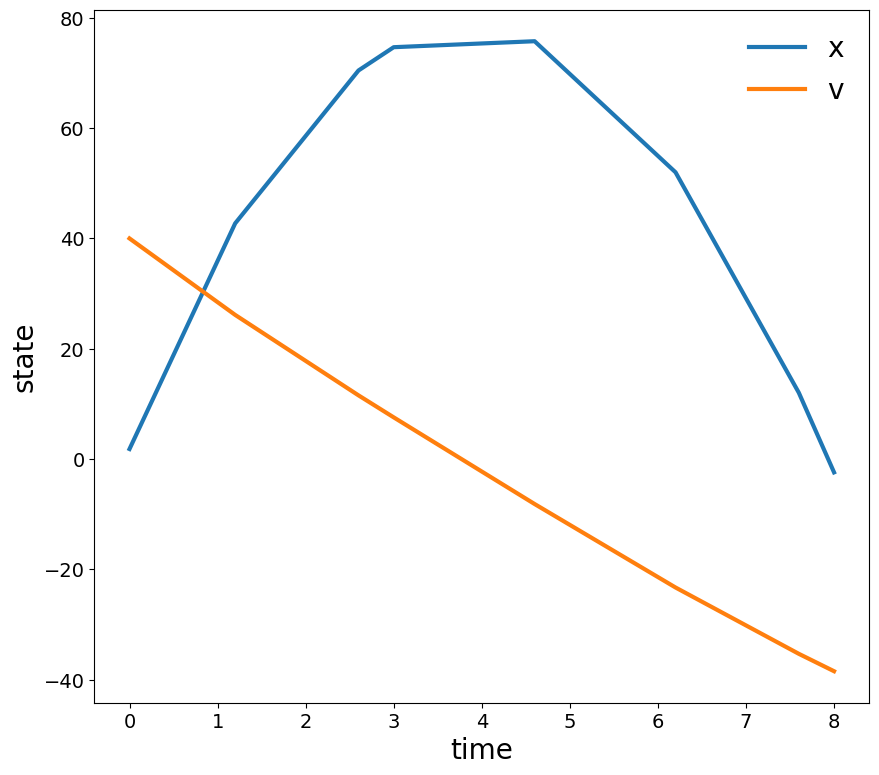

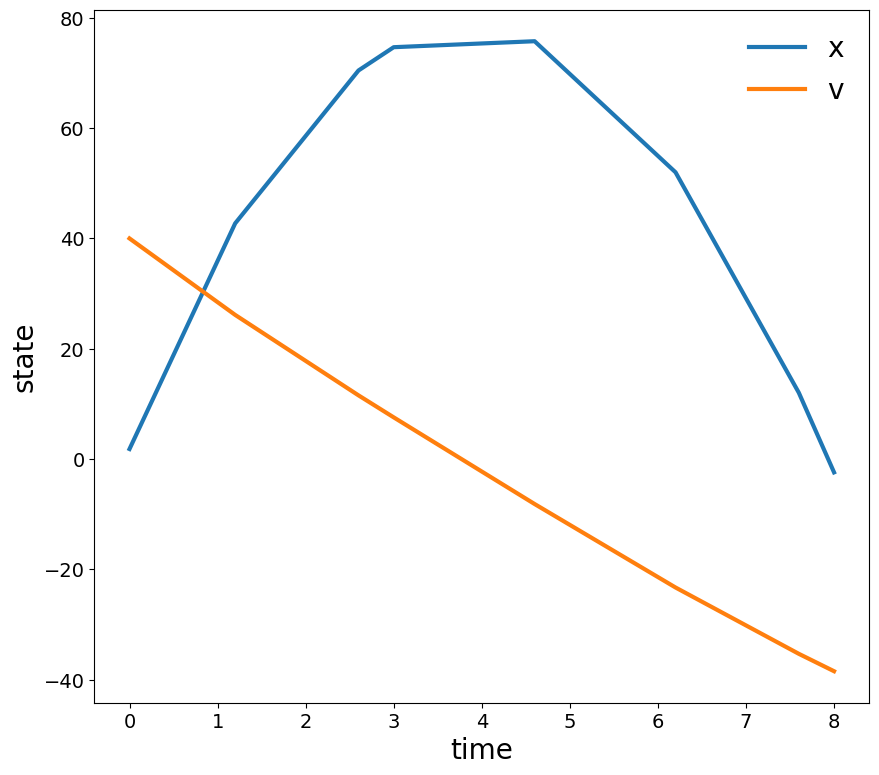

In [30]:
# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, dt=0.2, threshold_keys='impact', save_pts=[1, 2.5, 3, 4.5, 6, 7.5])

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

# Plot results
states.plot()

Note above that the state was captured at 2.6, 4.6, and 7.6 instead of the requested 2.5, 4.5, and 7.5. 

This can be fixed by auto step sizes. Let's repeat this example with automatic step sizes.

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	1.00s: {'x': 41.83, 'v': 27.82448275862069}
	2.50s: {'x': 83.56672413793103, 'v': 11.39255669360444}
	3.00s: {'x': 89.26300248473325, 'v': 6.391612535479811}
	4.50s: {'x': 98.85042128795297, 'v': -8.41398539429823}
	6.00s: {'x': 86.22944319650563, 'v': -22.971984942635057}
	7.50s: {'x': 51.771465782553044, 'v': -36.51669239332776}
	10.00s: {'x': -39.52026520076635, 'v': -56.11303068633767}


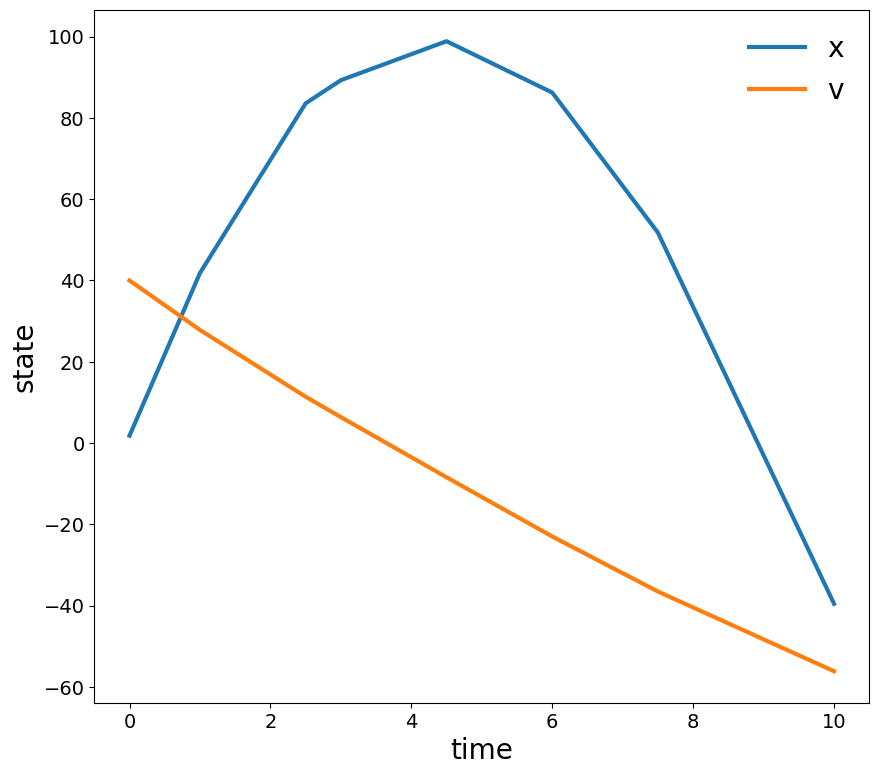

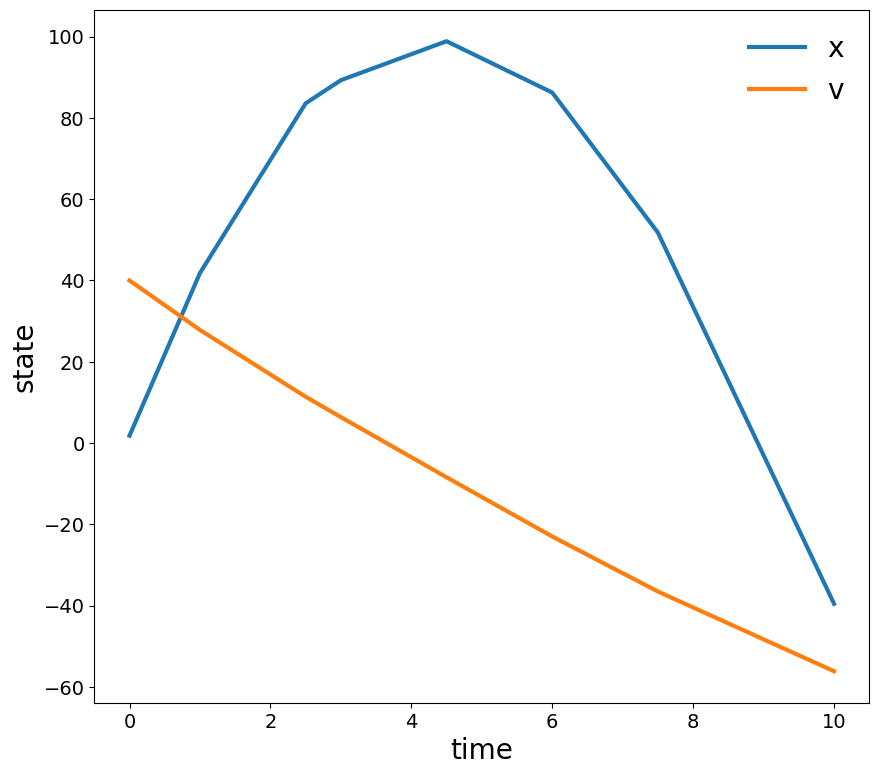

In [31]:
# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, dt='auto', threshold_keys='impact', save_pts=[1, 2.5, 3, 4.5, 6, 7.5])

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

# Plot results
states.plot()

Now the save_pts are captured exactly, but note that the resulting behavior is very different than the results of previous simulations. This is because we used an unbounded automatic step size. The simulation took larger steps than we should, resulting in error accumulation.

With bounded automatic step sizes we also provide the largest step it can take. This prevents the integrator from taking too large steps.

states:
	0.00s: {'x': 1.83, 'v': 40.0}
	1.00s: {'x': 37.06688934481376, 'v': 28.337893667581454}
	2.50s: {'x': 69.08483134414183, 'v': 12.565669829322761}
	3.00s: {'x': 74.56556433241622, 'v': 7.570188773510074}
	4.50s: {'x': 76.27179747648647, 'v': -7.163177096076779}
	6.00s: {'x': 56.09530525069033, 'v': -21.438594139312496}
	7.50s: {'x': 15.225336153151583, 'v': -34.47503736594601}
	8.10s: {'x': -6.419304389972532, 'v': -39.20513696061464}


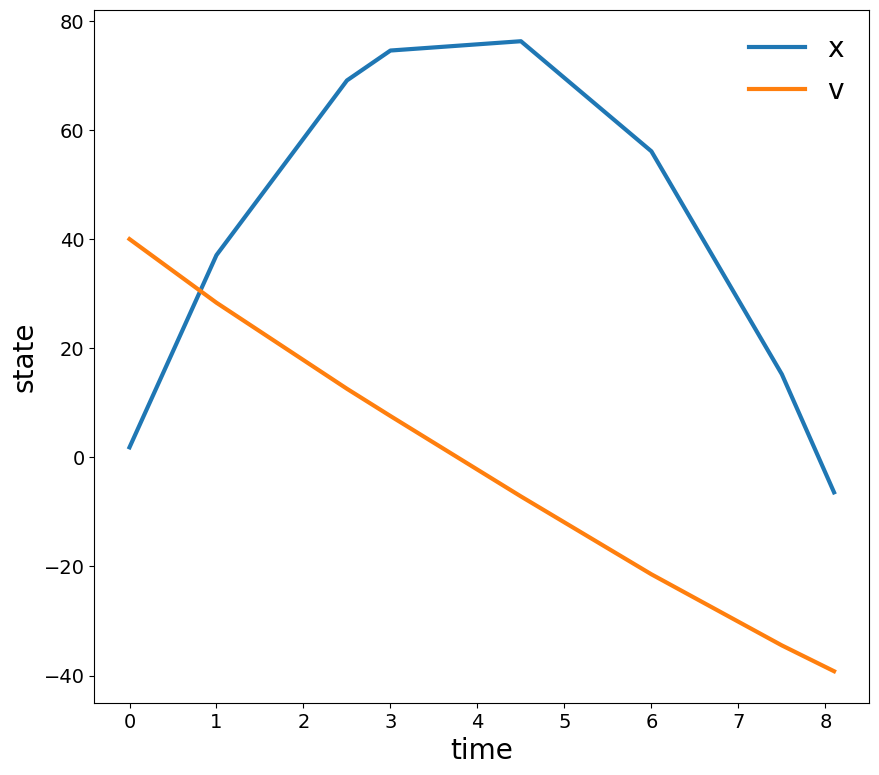

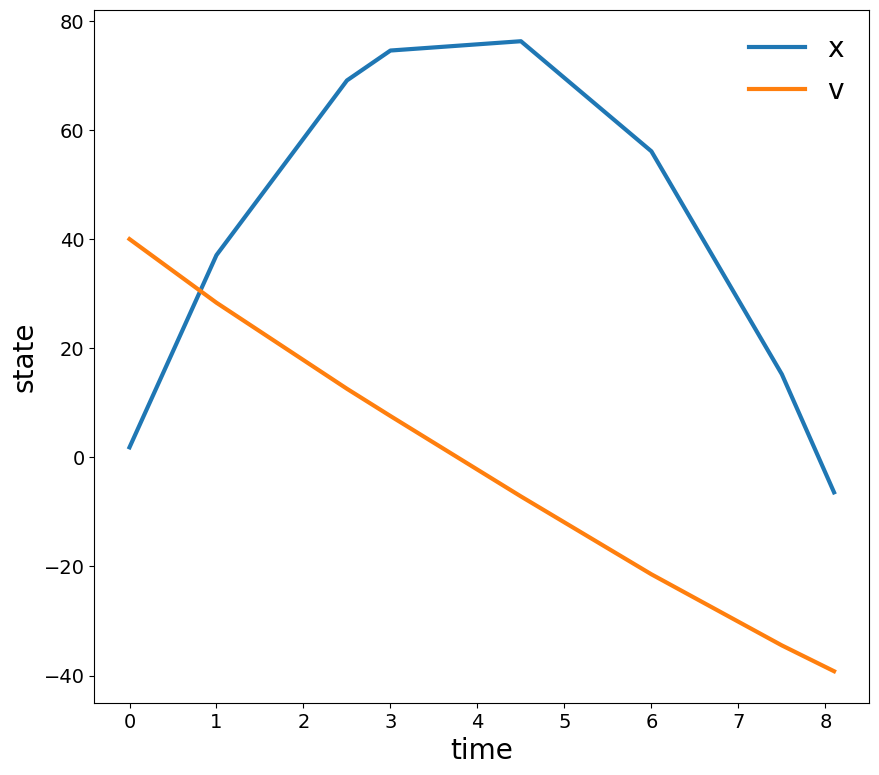

In [32]:
# Simulate to a threshold
(times, _, states, outputs, _) = m.simulate_to_threshold(future_load, dt=('auto', 0.2), threshold_keys='impact', save_pts=[1, 2.5, 3, 4.5, 6, 7.5])

# Print Results
print('states:')
for (t,x) in zip(times, states):
    print('\t{:.2f}s: {}'.format(t, x))

# Plot results
states.plot()

Now the simulation still captures every save point exactly, but it never takes a step size larger than 0.2 seconds, resulting in a better simulation.

You can also define more complex dynamic step sizes by providing a function (t, x)->dt. For example: `dt=lambda t, x: max(0.75 - t/100, 0.25)`

### Integration methods

Simulation is essentially the process of integrating the model forward with time. By default, simple euler integration is used to propogate the model forward. Advanced users can change the numerical integration method to affect the simulation quality and runtime. This is done using the `integration_method` argument in `simulate_to()`, `simulate_to_threshold()`, or the model parameters. For example:

`m.parameters['integration_method'] = 'rk4'`

Note: integration method can only be changed for continuous models. In this case our thrown object model is discrete, so we cannot demonstrate it on this model (see below).

In [34]:
m.is_continuous

False

Integration methods can also be set to scipy.integrate functions, for example:

`m.parameters['integration_method'] = scipy.integrate.Radau`

Any keyword arguments are then saved into `m.parameters['integrator_config']` as a dictionary

## Building a new model

To build a model, create a seperate class to define the logic of the model. Do this by copying the file `prog_model_template.py` and replacing the functions with the logic specific to your model. 

For this example, we will model the throwing of an object directly into the air in a vacuum. This is not a particularly interesting problem, but it is simple and illustrates the basic methods of a PrognosticsModel.

The model is illustrated below:

In [35]:
from prog_models import PrognosticsModel

class ThrownObject(PrognosticsModel):
    """
    Model that simulates an object thrown directly into the air (vertically) without air resistance
    """

    inputs = [] # no inputs, no way to control
    states = [
        'x', # Vertical position (m) 
        'v'  # Velocity (m/s)
        ]
    outputs = [ # Anything we can measure
        'x' # Position (m)
    ]
    events = [ # Events that can/will occur during simulation
        'falling', # Event- object is falling
        'impact' # Event- object has impacted ground
    ]

    # The Default parameters for any ThrownObject. 
    # Overwritten by passing parameters into constructor as kwargs or by setting model.parameters
    default_parameters = {
        'thrower_height': 1.83, # Height of thrower (m)
        'throwing_speed': 40, # Velocity at which the ball is thrown (m/s)
        'g': -9.81, # Acceleration due to gravity (m/s^2)
        'process_noise': 0.0 # amount of noise in each step
    }    

    # First function: Initialize. This function is used to initialize the first state of the model.
    # This is only needed in cases with complex initialization. 
    # In this case we need it because of max_x
    # If not included, parameters['x0'] is returned as the initial state
    # In this case we do not need input (u) or output (z) to initialize the model, 
    #   so we set them to None, but that's not true for every model.
    # u and z are Input and Output, respectively. 
    # Values can be accessed like a dictionary (e.g., z['x']) using the keys from inputs and outputs, respectively.
    # or they can be accessed using the matrix (i.e., z.matrix)
    def initialize(self, u=None, z=None):
        self.max_x = 0.0
        return self.StateContainer({
            'x': self.parameters['thrower_height'], # initial altitude is height of thrower
            'v': self.parameters['throwing_speed'] 
            })
    
    # Second function: state transition. 
    # State transition can be defined in one of two ways:
    #   1) Discrete models use next_state(x, u, dt) -> x'
    #   2) Continuous models (preferred) use dx(x, u) -> dx/dt
    #
    # In this case we choose the continuous model, so we define dx(x, u)
    # This function defines the first derivative of the state with respect to time, as a function of model configuration (self.parameters), state (x) and input (u).
    # Here input isn't used. But past state and configuration are.
    # 
    # x and u are State and Input, respectively. 
    # Values can be accessed like a dictionary (e.g., x['x']) using the keys from states and inputs, respectively.
    # or they can be accessed using the matrix (i.e., x.matrix)
    def dx(self, x, u):
        return self.StateContainer({
            'x': x['v'],  # dx/dt = v
            'v': self.parameters['g'] # Acceleration of gravity
        })
    # Equivalently, the state transition could have been defined as follows:
    # def next_state(self, x, u, dt):
    #     return self.StateContainer({
    #         'x': x['x'] + x['v']*dt,
    #         'v': x['v'] + self.parameters['g']*dt
    #     })

    # Now, we define the output equation. 
    # This function estimates the output (i.e., measured values) given the system state (x) and system parameters (self.parameters).
    # In this example, we're saying that the state 'x' can be directly measured. 
    # But in most cases output will have to be calculated from state. 
    def output(self, x):
        return self.OutputContainer({
            'x': x['x']
        })

    # Next, we define the event state equation
    # This is the first equation that actually describes the progress of a system towards the events.
    # This function maps system state (x) and system parameters (self.parameters) to event state for each event.
    # Event state is defined as a number between 0 and 1 where 1 signifies no progress towards the event, and 0 signifies the event has occurred.
    # The event keys were defined above (model.events)
    # Here the two event states are as follows:
    #  1) falling: 1 is defined as when the system is moving at the maximum speed (i.e., throwing_speed), and 0 is when velocity is negative (i.e., falling)
    #  2) impact: 1 is defined as the ratio of the current altitude (x) to the maximum altitude (max_x), and 0 is when the current altitude is 0 (i.e., impact)
    def event_state(self, x): 
        self.max_x = max(self.max_x, x['x']) # Maximum altitude
        return {
            'falling': max(x['v']/self.parameters['throwing_speed'],0), # Throwing speed is max speed
            'impact': max(x['x']/self.max_x,0) # Ratio of current altitude to maximum altitude
        }

    # Finally, we define the threshold equation.
    # This is the second equation that describes the progress of a system towards the events.
    # Note: This function is optional. If not defined, threshold_met will be defined as when the event state is 0.
    # However, this implementation is more efficient, so we included it
    # This function maps system state (x) and system parameters (self.parameters) a boolean indicating if the event has been met for each event.
    def threshold_met(self, x):
        return {
            'falling': x['v'] < 0,
            'impact': x['x'] <= 0
        }


Now the model can be generated and used like any of the other provided models

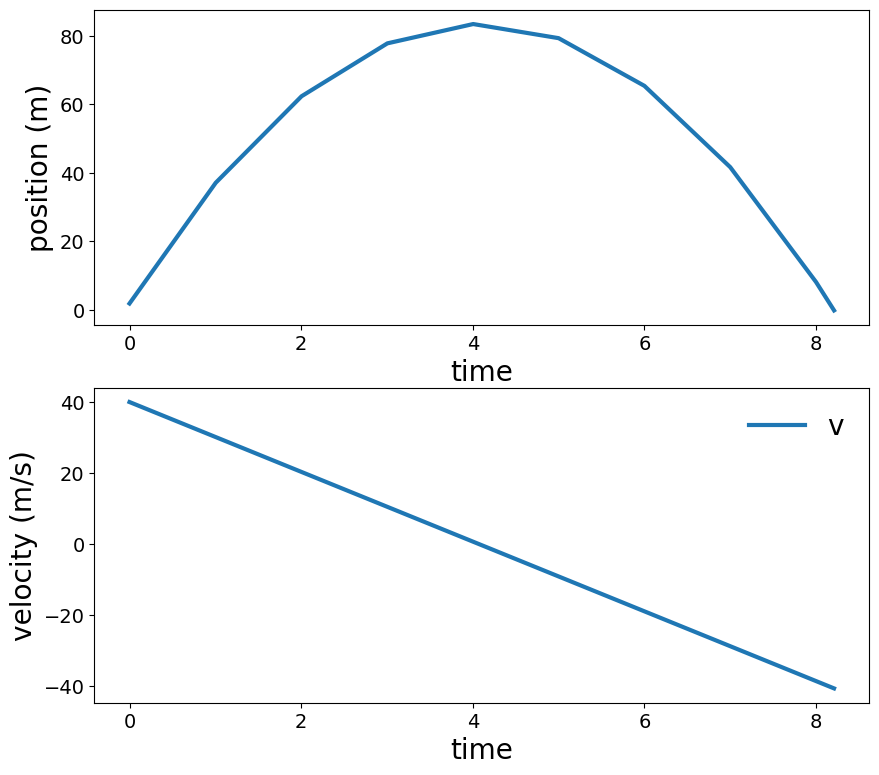

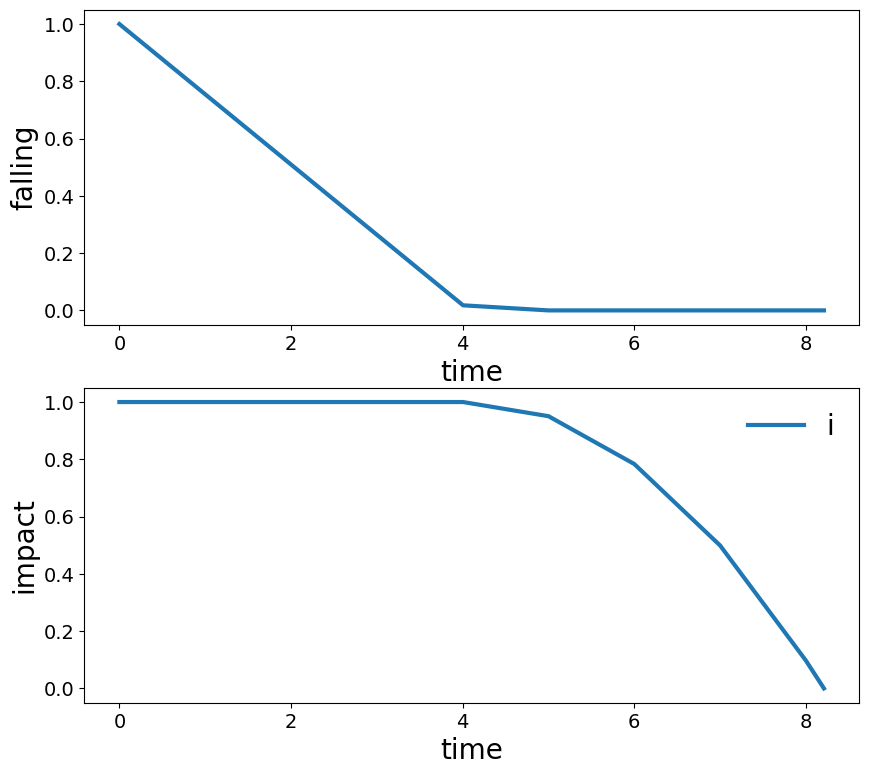

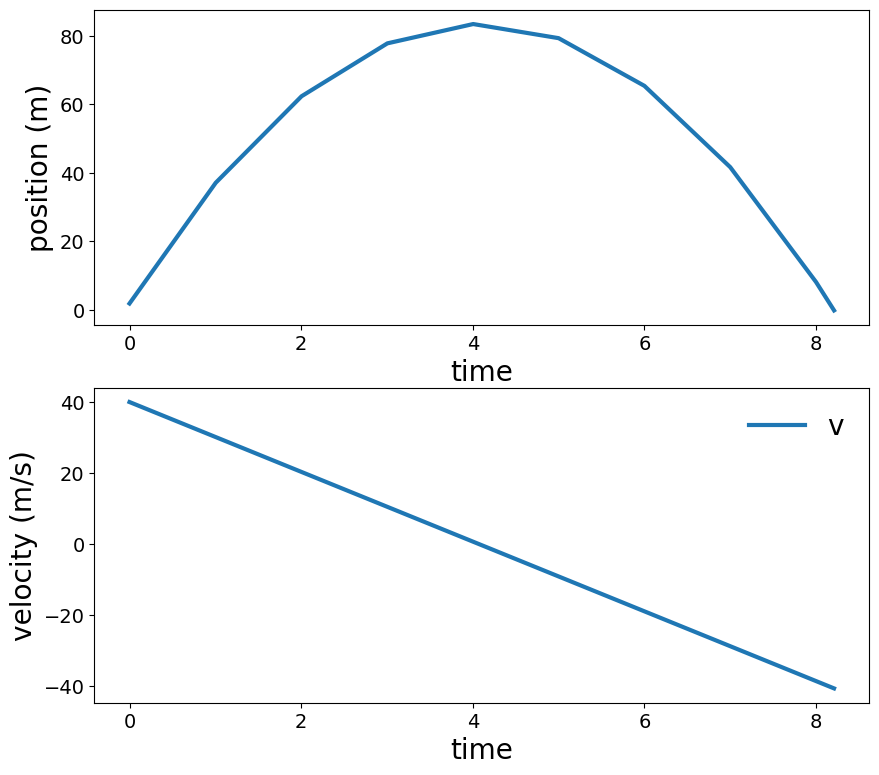

In [36]:
m = ThrownObject()

def future_load(t, x=None):
        return m.InputContainer({}) # No loading
event = 'impact'  # Simulate until impact

(times, inputs, states, outputs, event_states) = m.simulate_to_threshold(future_load, threshold_keys=[event], dt=0.005, save_freq=1)

# Plot results
event_states.plot(ylabel= ['falling', 'impact'], compact= False)
states.plot(ylabel= {'x': "position (m)", 'v': 'velocity (m/s)'}, compact= False)

Note: The plots are at the resolution of save_freq (one point per second)

See also `examples.new_model` for more information on building models

## Building a new model - advanced

### Derived Parameters 

Models can also include "derived parameters" (i.e., parameters that are derived from others). These can be set using the param_callbacks property. 

Let's extend the above model to include derived_parameters. Let's say that the throwing_speed was actually a function of thrower_height (i.e., a taller thrower would throw the ball faster). Here's how we would implement that

In [37]:
# Step 1: Define a function for the relationship between thrower_height and throwing_speed.
def update_thrown_speed(params):
    return {
        'throwing_speed': params['thrower_height'] * 21.85
    }  # Assumes thrown_speed is linear function of height

# Step 2: Define the param callbacks
ThrownObject.param_callbacks = {
        'thrower_height': [update_thrown_speed]
    }  # Tell the derived callbacks feature to call this function when thrower_height changes.

Note: Usually we would define this method within the class. For this example, we're doing it separately to improve readability. Here's the feature in action

In [38]:
obj = ThrownObject()
print("Default Settings:\n\tthrower_height: {}\n\tthowing_speed: {}".format(obj.parameters['thrower_height'], obj.parameters['throwing_speed']))

# Now let's change the thrower_height
print("changing height...")
obj.parameters['thrower_height'] = 1.75  # Our thrower is 1.75 m tall
print("\nUpdated Settings:\n\tthrower_height: {}\n\tthowing_speed: {}".format(obj.parameters['thrower_height'], obj.parameters['throwing_speed']))
print("Notice how speed changed automatically with height")

# Let's delete the callback so we can use the same model in the future:
ThrownObject.param_callbacks = {}

Default Settings:
	thrower_height: 1.83
	thowing_speed: 39.9855
changing height...

Updated Settings:
	thrower_height: 1.75
	thowing_speed: 38.237500000000004
Notice how speed changed automatically with height


### State Limits

In many cases, the values of the model states have certain physical limits. For example, temperature is limited by absolute zero. In these cases, it is useful to define those limits. In simulation, the defined limits are enforced as the state transitions to prevent the system from reaching an impossible state.

For example, the ThrownObject model can be extended as follows:

In [39]:
from numpy import inf

ThrownObject.state_limits = {
        # object may not go below ground
        'x': (0, inf),

        # object may not exceed the speed of light
        'v': (-299792458, 299792458)
    }

Note: like derived parameters, these would typically be defined in class definition, not afterwards. They are defined afterwards in this case to illustrate the feature.

State limits can be applied directly using the apply_limits function. For example:

In [40]:
x = {'x': -5, 'v': 3e8} # Too fast and below the ground
x = obj.apply_limits(x)
print(x)

{'x': 0, 'v': 299792458.0}


/Users/cteubert/dev/prog_models/src/prog_models/prognostics_model.py:413: ProgModelStateLimitWarning: State x limited to 0 (was -5)
  warn("State {} limited to {} (was {})".format(key, limit[0], x[key]), ProgModelStateLimitWarning)
/Users/cteubert/dev/prog_models/src/prog_models/prognostics_model.py:416: ProgModelStateLimitWarning: State v limited to 299792458 (was 300000000.0)
  warn("State {} limited to {} (was {})".format(key, limit[1], x[key]), ProgModelStateLimitWarning)


Notice how the state was limited according to the model state limits and a warning was issued. The warning can be suppressed by suppressing ProgModelStateLimitWarning (`warnings.simplefilter('ignore', ProgModelStateLimitWarning)`)

See also examples.derived_params for more information on this feature.

## Parameter Estimation

Let's say we don't know the configuration of the above model. Instead, we have some data. We can use that data to estimate the parameters. 

First, we define the data:

In [41]:
times = [0, 1, 2, 3, 4, 5, 6, 7, 8]
inputs = [{}]*9
outputs = [
    {'x': 1.83},
    {'x': 36.95},
    {'x': 62.36},
    {'x': 77.81},
    {'x': 83.45},
    {'x': 79.28},
    {'x': 65.3},
    {'x': 41.51},
    {'x': 7.91},
]

Next, we identify which parameters will be optimized

In [42]:
keys = ['thrower_height', 'throwing_speed']

Let's say we have a first guess that the thrower's height is 20m, silly I know

In [43]:
m.parameters['thrower_height'] = 20

Here's the state of our estimation with that assumption:

In [44]:
print('Model configuration before')
for key in keys:
    print("-", key, m.parameters[key])
print(' Error: ', m.calc_error(times, inputs, outputs, dt=1e-4))

Model configuration before
- thrower_height 20
- throwing_speed 40
 Error:  328.00560309157913


Wow, that's a large error. 

Let's run the parameter estimation to see if we can do better

In [45]:
m.estimate_params([(times, inputs, outputs)], keys, dt=0.01)

# Print result
print('\nOptimized configuration')
for key in keys:
    print("-", key, m.parameters[key])
print(' Error: ', m.calc_error(times, inputs, outputs, dt=1e-4))


Optimized configuration
- thrower_height 1.9077953978492042
- throwing_speed 39.94677550314997
 Error:  0.05599754057586332


Much better!

See also examples.param_est for more details about this feature

## Conclusion
This is just the basics, there's much more to learn. Please see the documentation at <https://nasa.github.io/progpy/guide> and the examples in the `examples/` folder for more details on how to use the package, including:
* `examples.derived_params` : Example building models with derived parameters.
* `examples.state_limits`: Example building models with limits on state variables.
* `examples.param_est`: Example using the parameter estimation feature 
* `examples.dynamic_step_size`: Example simulating with dynamic (i.e., changing as a function of time or state) step size.
* `examples.events`: Example extending a model to include additional events, such as warning thresholds.
* `examples.generate_surrogate`: Example generating a surrogate model
* `examples.linear_model`: Example using the new Linear Model subclass
* `examples.benchmarking`: Example benchmarking the performance of a Prognostics Model
* `examples.future_loading`: Example with complex future loading schemes
* `examples.new_model`: Example building a new model
* `examples.noise`: Example demonstrating how noise can be added in simulation
* `examples.vectorized`: Example simulating a vectorized model
* `examples.sim`, `examples.sim_battery_eol`, `examples.sim_pump`, `examples.sim_valve`, `examples.sim_powertrain`, `examples.sim_dcmotor_singlephase`: Examples using specific models from `prog_models.models`
* `examples.lstm_model`, `examples.full_lstm_model`, and `examples.custom_model`: Examples using data-driven models

Thank you for trying out this tutorial. Open an issue on github (https://github.com/nasa/prog_models/issues) or email Chris Teubert (christopher.a.teubert@nasa.gov) with any questions or issues.

Copyright © 2021 United States Government as represented by the Administrator of the National Aeronautics and Space Administration.  All Rights Reserved.